## Import Libraries

In [1]:
# to read and wrangle data
import pandas as pd

# to import data from LA Data portal
from sodapy import Socrata

# to create spatial data
import geopandas as gpd

# for basemaps
import contextily as ctx

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

# Graphics
import matplotlib.pyplot as plt
import plotly.express as px

# Census Tract To Neighborhood Function
It takes census tract level geospatial data and dissolves it into neighborhood shapes. 
The arguments you need are your data frame (i.e. 'df= your data frame', your geometry column, usually named 'geometry' (i.e. "geometry='geometry'", and lastly how you want the variables to be summarized (i.e. 'sum' to add or 'mean' for an average)

In [2]:
def nhdissolve(df,geometry,math,skip=False):
    
    #Import neighborhood shapes
    url = "https://usc.data.socrata.com/api/geospatial/r8qd-yxsr?method=export&format=GeoJSON"
    nhoods=gpd.read_file(url)
   
    #This is to make the geography column recognizable, toggling skip to True allows you to avoid an error message if your geometry column does not need this operation
    runwkts=skip
    if runwkts==False:
        df[geometry] = df[geometry].apply(wkt.loads)
    #add a CRS
    gdf = gpd.GeoDataFrame(df, crs="EPSG:4326",geometry='geometry')
     #join race with nh shapes, rename neighborhood column, and set it as the index
    nhjoin=gdf.overlay(nhoods, how='intersection')
    nhjoin=nhjoin.rename(columns={'name':'Neighborhood'})
    nhjoin.set_index('Neighborhood',inplace=True)
    
    #drop shapes not in city of LA
    nhjoin.drop(nhjoin[nhjoin['type'] != 'segment-of-a-city'].index, inplace = True)

    #approximate average for data in neighborhoods 
    nhdata= nhjoin.dissolve(by='Neighborhood', aggfunc= math)
    nhdata.head()
    return nhdata

### TCAC Shapefile

In [3]:
#Import the TCAC data
url = "https://www.treasurer.ca.gov/ctcac/opportunity/2023/final_2023_shapefile.zip"

In [4]:
TCAC = gpd.read_file(url)

<AxesSubplot: >

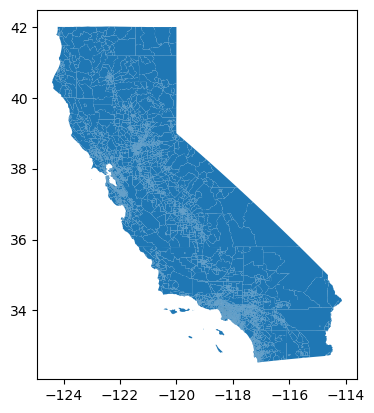

In [5]:
TCAC.plot()

In [6]:
TCAC.head()

fips fips_bg  cnty_nm countyd           region   ecn_dmn   env_hl_  \
0  06001400100    None  Alameda   06001  Bay Area Region  0.796927  0.927856   
1  06001400200    None  Alameda   06001  Bay Area Region  0.960588  0.627255   
2  06001400300    None  Alameda   06001  Bay Area Region  0.927188  0.619238   
3  06001400400    None  Alameda   06001  Bay Area Region  0.872411  0.657983   
4  06001400500    None  Alameda   06001  Bay Area Region  0.759519  0.698063   

    ed_domn     index            oppcat  \
0  0.787575  0.590095  Highest Resource   
1  0.810955  0.701320  Highest Resource   
2  0.324649  0.210942     High Resource   
3  0.523046  0.358539     High Resource   
4  0.566466  0.310218     High Resource   

                                            geometry  
0  POLYGON ((-122.23418 37.85254, -122.23428 37.8...  
1  POLYGON ((-122.25253 37.85110, -122.25094 37.8...  
2  POLYGON ((-122.26417 37.83787, -122.26427 37.8...  
3  POLYGON ((-122.26081 37.84869, -122.26023 37.8...  
4  POLYGON ((-122.26023 37.85274, -122.26081 37.8...

In [7]:
#Using the census tract to neighborhood dissolve function
TCACNeighborhoods= nhdissolve(df=TCAC,geometry='geometry',math='sum',skip=True)

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:2323: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(
/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc)


In [8]:
#Check the data
TCACNeighborhoods.head()

geometry  \
Neighborhood                                                                
Adams-Normandie         POLYGON ((-118.30541 34.02571, -118.30889 34.0...   
Arleta                  POLYGON ((-118.43826 34.23318, -118.44082 34.2...   
Arlington Heights       POLYGON ((-118.33381 34.03501, -118.33271 34.0...   
Atwater Village         POLYGON ((-118.26584 34.11413, -118.26836 34.1...   
Baldwin Hills/Crenshaw  POLYGON ((-118.35682 33.99796, -118.35717 33.9...   

                          ecn_dmn    env_hl_   ed_domn     index  
Neighborhood                                                      
Adams-Normandie          4.448944   3.789173  2.466989 -3.069191  
Arleta                   4.655370   3.159771  4.298415 -4.564345  
Arlington Heights        9.000880   6.520246  4.423856 -0.655180  
Atwater Village          5.915933   1.094630  6.420335 -0.458471  
Baldwin Hills/Crenshaw  10.906690  10.032130  3.428697 -1.004346

In [9]:
#Check CRS of the data
TCACNeighborhoods.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
#Convert the CRS into mercator projection
TCACNeighborhoods_web_mercator = TCACNeighborhoods.to_crs(epsg=3857)

In [11]:
#Import neighborhood outline data
neighborhoods = gpd.read_file("https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/LA_Times_Neighborhoods/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson")

In [12]:
#Check CRS of the data + convert the CRS into mercator projection
neighborhoods_web_mercator = neighborhoods.to_crs(epsg=3857)

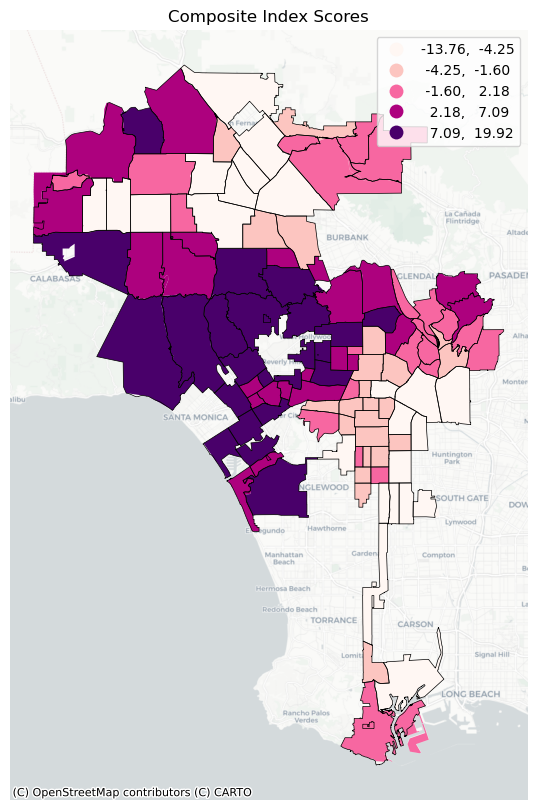

In [13]:
#Plot the data
fig, ax = plt.subplots(figsize=(20, 10))
TCACNeighborhoods_web_mercator.plot(
                 column='index',
                 cmap='RdPu',
                 legend=True, 
                 scheme='quantiles',
                 ax=ax)

neighborhoods_web_mercator.plot(
            ax=ax,                
            color = "none",        
            edgecolor = 'black',
            linewidth = 0.5,
            )

# turn the axes off
ax.axis('off')

# give it a title
ax.set_title('Composite Index Scores')

# add a basemap
ctx.add_basemap(ax, crs=3857, source=ctx.providers.CartoDB.Positron)

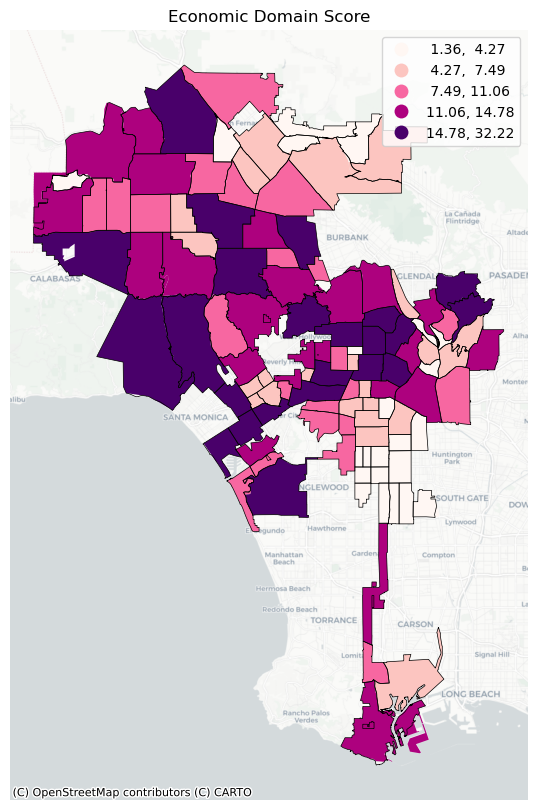

In [14]:
#Plot the data
fig, ax = plt.subplots(figsize=(20, 10))
TCACNeighborhoods_web_mercator.plot(
                 column='ecn_dmn',
                 cmap='RdPu',
                 legend=True, 
                 scheme='quantiles',
                 ax=ax)

neighborhoods_web_mercator.plot(
            ax=ax,                
            color = "none",        
            edgecolor = 'black',
            linewidth = 0.5,
            )

# turn the axes off
ax.axis('off')

# give it a title
ax.set_title('Economic Domain Score')

# add a basemap
ctx.add_basemap(ax, crs=3857, source=ctx.providers.CartoDB.Positron)

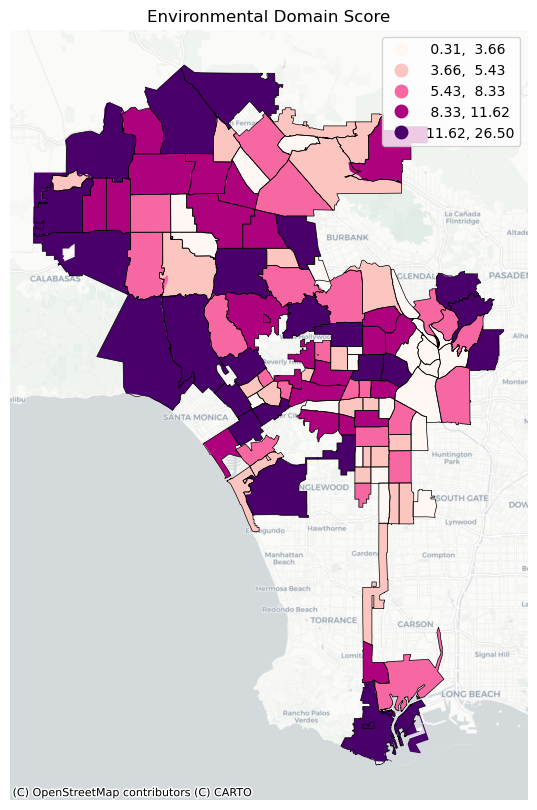

In [15]:
#Plot the data
fig, ax = plt.subplots(figsize=(20, 10))
TCACNeighborhoods_web_mercator.plot(
                 column='env_hl_',
                 cmap='RdPu',
                 legend=True, 
                 scheme='quantiles',
                 ax=ax)

neighborhoods_web_mercator.plot(
            ax=ax,                
            color = "none",        
            edgecolor = 'black',
            linewidth = 0.5,
            )

# turn the axes off
ax.axis('off')

# give it a title
ax.set_title('Environmental Domain Score')

# add a basemap
ctx.add_basemap(ax, crs=3857, source=ctx.providers.CartoDB.Positron)

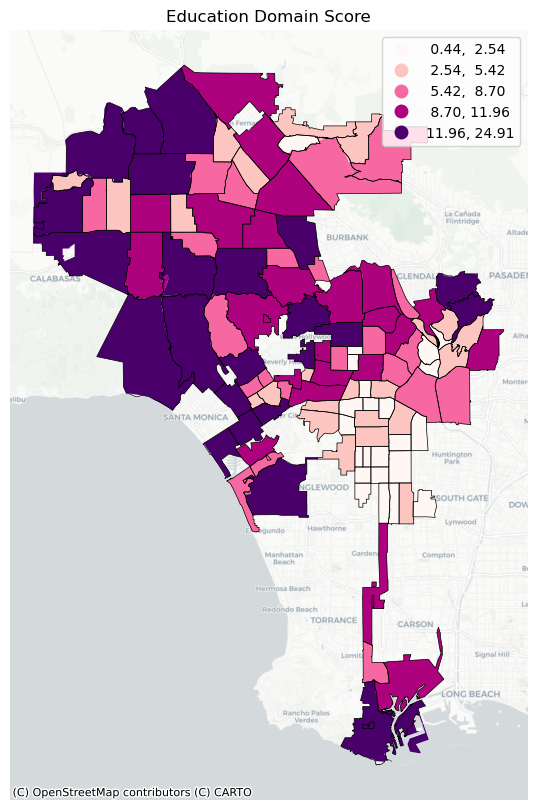

In [16]:
#Plot the data
fig, ax = plt.subplots(figsize=(20, 10))
TCACNeighborhoods_web_mercator.plot(
                 column='ed_domn',
                 cmap='RdPu',
                 legend=True, 
                 scheme='quantiles',
                 ax=ax)

neighborhoods_web_mercator.plot(
            ax=ax,                
            color = "none",        
            edgecolor = 'black',
            linewidth = 0.5,
            )

# turn the axes off
ax.axis('off')

# give it a title
ax.set_title('Education Domain Score')

# add a basemap
ctx.add_basemap(ax, crs=3857, source=ctx.providers.CartoDB.Positron)

# Spatial Autocorrelation

Does opportunity (as measured by the TCAC scores) have a statistical significant tendency to cluster in certain communities? We are seeking to see where spatial correlations occur based on the data


<AxesSubplot: >

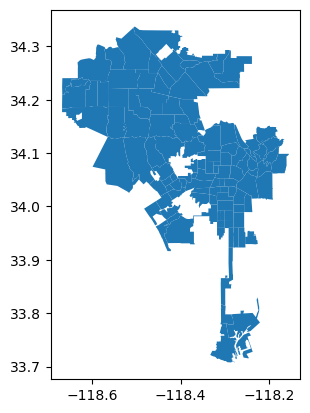

In [17]:
TCACNeighborhoods.plot()

In [18]:
# calculate spatial weight
wq =  lps.weights.KNN.from_dataframe(TCACNeighborhoods,k=8)

# Row-standardization
wq.transform = 'r'

Create a new column for the spatial lag

In [19]:
TCACNeighborhoods['ecn_dmn_lag'] = lps.weights.lag_spatial(wq, TCACNeighborhoods['ecn_dmn'])

In [20]:
TCACNeighborhoods['env_hl_lag'] = lps.weights.lag_spatial(wq, TCACNeighborhoods['env_hl_'])

In [21]:
TCACNeighborhoods['ed_domn_lag'] = lps.weights.lag_spatial(wq, TCACNeighborhoods['ed_domn'])

In [22]:
TCACNeighborhoods['index_lag'] = lps.weights.lag_spatial(wq, TCACNeighborhoods['index'])

In [23]:
TCACNeighborhoods.sample(10)

geometry  \
Neighborhood                                                           
South Park         POLYGON ((-118.28051 33.99501, -118.28056 33.9...   
Vermont Vista      POLYGON ((-118.29156 33.93096, -118.29156 33.9...   
Shadow Hills       POLYGON ((-118.34132 34.20653, -118.34281 34.2...   
Carthay            POLYGON ((-118.37613 34.05329, -118.37621 34.0...   
Downtown           POLYGON ((-118.24401 34.02091, -118.25331 34.0...   
Toluca Lake        POLYGON ((-118.36180 34.14345, -118.36328 34.1...   
Bel-Air            POLYGON ((-118.46338 34.07402, -118.46402 34.0...   
Arlington Heights  POLYGON ((-118.33381 34.03501, -118.33271 34.0...   
Mission Hills      POLYGON ((-118.47202 34.25732, -118.47201 34.2...   
San Pedro          MULTIPOLYGON (((-118.32845 33.72942, -118.3244...   

                     ecn_dmn    env_hl_    ed_domn     index  ecn_dmn_lag  \
Neighborhood                                                                
South Park          3.517165   4.070863   1.069542 -4.251800     3.481624   
Vermont Vista       2.946303   2.983275   0.443222 -7.499275     3.118178   
Shadow Hills        5.720070   4.175176   6.146127 -0.314638     7.525044   
Carthay             6.754842   4.302377   4.752641  4.612205    12.493398   
Downtown           13.464789   2.217430   5.452025 -5.523826     7.572678   
Toluca Lake         8.512764   3.171655   6.153609  2.869468    15.130997   
Bel-Air             8.783891   5.682658   8.493398  9.268712    14.437555   
Arlington Heights   9.000880   6.520246   4.423856 -0.655180    11.084067   
Mission Hills       4.125000   3.867518   4.085387 -2.834167    10.019927   
San Pedro          11.958187  18.709947  14.025968  1.609852     5.466989   

                   env_hl_lag  ed_domn_lag  index_lag  
Neighborhood                                           
South Park           4.869608     2.146017  -4.152492  
Vermont Vista        4.749065     1.397392  -5.270453  
Shadow Hills         6.139018     7.836697  -3.251549  
Carthay              7.646842     8.454886   6.545129  
Downtown             5.596941     4.170940  -4.910980  
Toluca Lake          9.214789    11.894861   5.569294  
Bel-Air             10.096171    14.735090  12.693562  
Arlington Heights    8.577025     5.132482   0.647623  
Mission Hills        9.770158    10.189635  -5.567913  
San Pedro            5.653829     4.610365  -6.941618

In [24]:
#Convert CRS to web mercator
TCACNeighborhoods_web_mercator = TCACNeighborhoods.to_crs(epsg=3857)

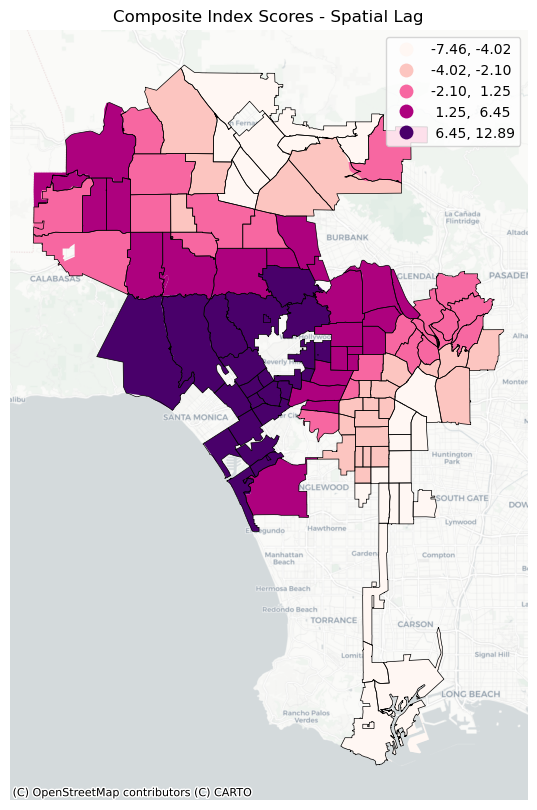

In [25]:
#Plot the data
fig, ax = plt.subplots(figsize=(20, 10))
TCACNeighborhoods_web_mercator.plot(
                 column='index_lag',
                 cmap='RdPu',
                 legend=True, 
                 scheme='quantiles',
                 ax=ax)

neighborhoods_web_mercator.plot(
            ax=ax,                
            color = "none",        
            edgecolor = 'black',
            linewidth = 0.5,
            )

# turn the axes off
ax.axis('off')

# give it a title
ax.set_title('Composite Index Scores - Spatial Lag')

# add a basemap
ctx.add_basemap(ax, crs=3857, source=ctx.providers.CartoDB.Positron)

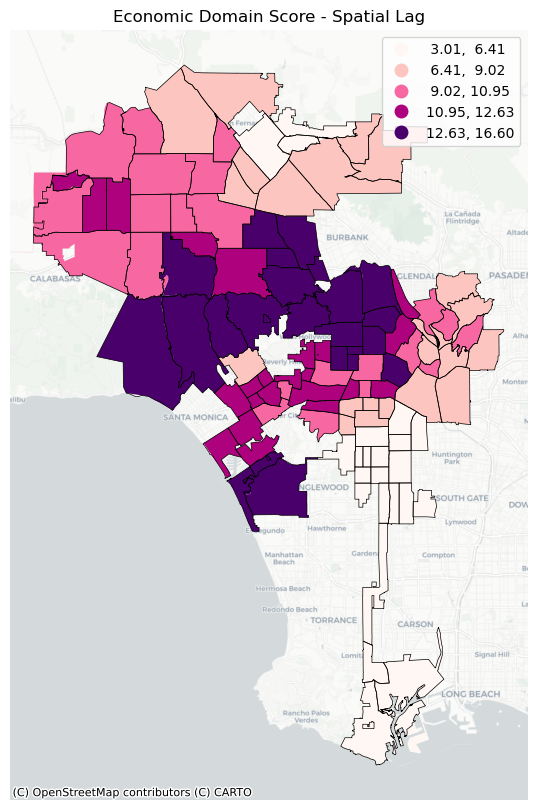

In [26]:
#Plot the data
fig, ax = plt.subplots(figsize=(20, 10))
TCACNeighborhoods_web_mercator.plot(
                 column='ecn_dmn_lag',
                 cmap='RdPu',
                 legend=True, 
                 scheme='quantiles',
                 ax=ax)

neighborhoods_web_mercator.plot(
            ax=ax,                
            color = "none",        
            edgecolor = 'black',
            linewidth = 0.5,
            )

# turn the axes off
ax.axis('off')

# give it a title
ax.set_title('Economic Domain Score - Spatial Lag')

# add a basemap
ctx.add_basemap(ax, crs=3857, source=ctx.providers.CartoDB.Positron)

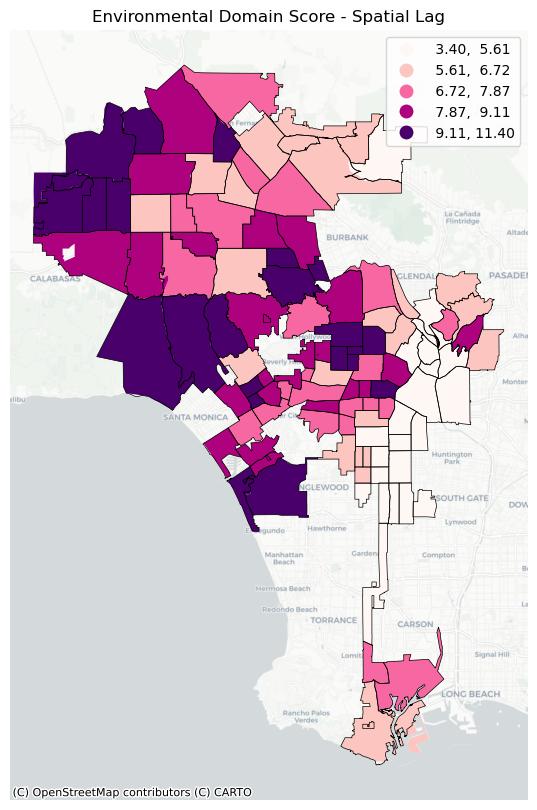

In [27]:
#Plot the data
fig, ax = plt.subplots(figsize=(20, 10))
TCACNeighborhoods_web_mercator.plot(
                 column='env_hl_lag',
                 cmap='RdPu',
                 legend=True, 
                 scheme='quantiles',
                 ax=ax)

neighborhoods_web_mercator.plot(
            ax=ax,                
            color = "none",        
            edgecolor = 'black',
            linewidth = 0.5,
            )

# turn the axes off
ax.axis('off')

# give it a title
ax.set_title('Environmental Domain Score - Spatial Lag')

# add a basemap
ctx.add_basemap(ax, crs=3857, source=ctx.providers.CartoDB.Positron)

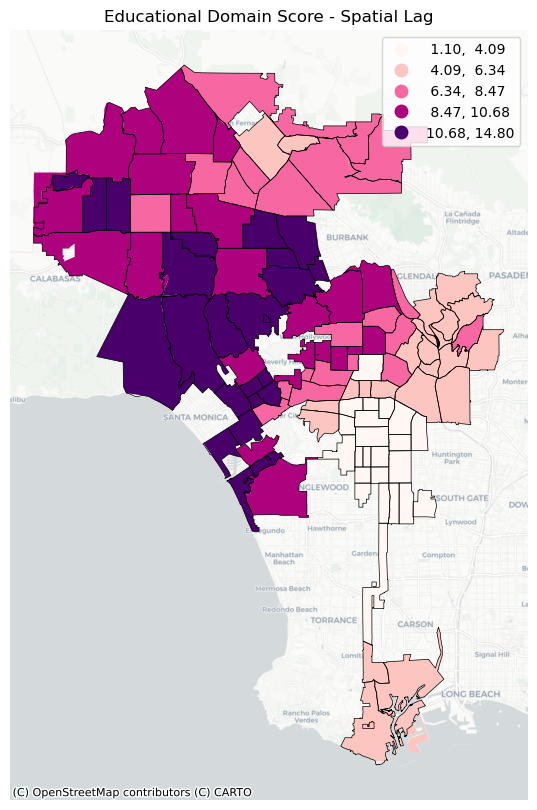

In [28]:
#Plot the data
fig, ax = plt.subplots(figsize=(20, 10))
TCACNeighborhoods_web_mercator.plot(
                 column='ed_domn_lag',
                 cmap='RdPu',
                 legend=True, 
                 scheme='quantiles',
                 ax=ax)

neighborhoods_web_mercator.plot(
            ax=ax,                
            color = "none",        
            edgecolor = 'black',
            linewidth = 0.5,
            )

# turn the axes off
ax.axis('off')

# give it a title
ax.set_title('Educational Domain Score - Spatial Lag')

# add a basemap
ctx.add_basemap(ax, crs=3857, source=ctx.providers.CartoDB.Positron)

### I have now produced spatial lag maps: maps that display geographies weighted against the values of its neighbors

In [29]:
# calculate spatial weight
wq =  lps.weights.KNN.from_dataframe(TCACNeighborhoods,k=8)

# Row-standardization
wq.transform = 'r'

# Looking at the economic, environmental, and educational domain - Moran's I value - a positive spatial autocorrelation: high values are close to high values, and/or low values are close to low values (for all three domains)

In [30]:
# economic domain - Positive spatial autocorrelation: high values are close to high values, and/or low values are close to low values
y = TCACNeighborhoods.ecn_dmn
moran_economic = Moran(y, wq)
moran_economic.I

0.2554325918902405

In [31]:
# environmental domain - Positive spatial autocorrelation: high values are close to high values, and/or low values are close to low values
y = TCACNeighborhoods.env_hl_
moran_enviro = Moran(y, wq)
moran_enviro.I

0.09346334120700069

In [32]:
# educational domain - Positive spatial autocorrelation: high values are close to high values, and/or low values are close to low values
y = TCACNeighborhoods.ed_domn
moran_education = Moran(y, wq)
moran_education.I

0.3611579218564291

### So what is the significance of our Moran value? In other words, how likely is our observed pattern on the map generated by an entirely random process? We can examine the P-value for each of the 3 Domains

# Economic Domain

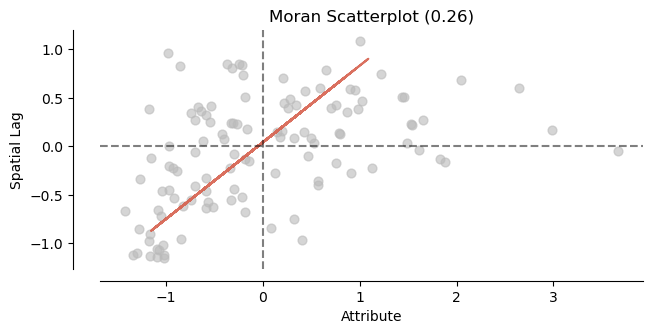

In [33]:
fig, ax = moran_scatterplot(moran_economic, aspect_equal=True)
plt.show()

/opt/conda/lib/python3.10/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


(<Figure size 700x700 with 1 Axes>,
 <AxesSubplot: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.26', ylabel='Density'>)

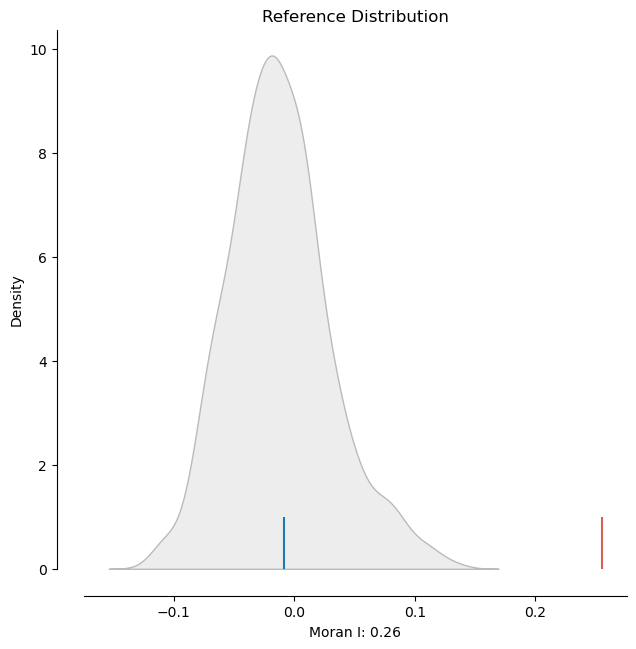

In [34]:
plot_moran_simulation(moran_economic,aspect_equal=False)

In [35]:
moran_economic.p_sim

0.001

# Environmental Domain


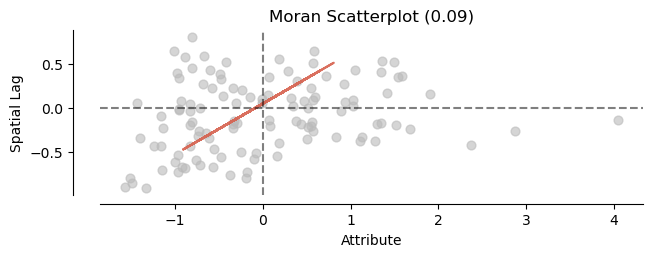

In [36]:
fig, ax = moran_scatterplot(moran_enviro, aspect_equal=True)
plt.show()

/opt/conda/lib/python3.10/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


(<Figure size 700x700 with 1 Axes>,
 <AxesSubplot: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.09', ylabel='Density'>)

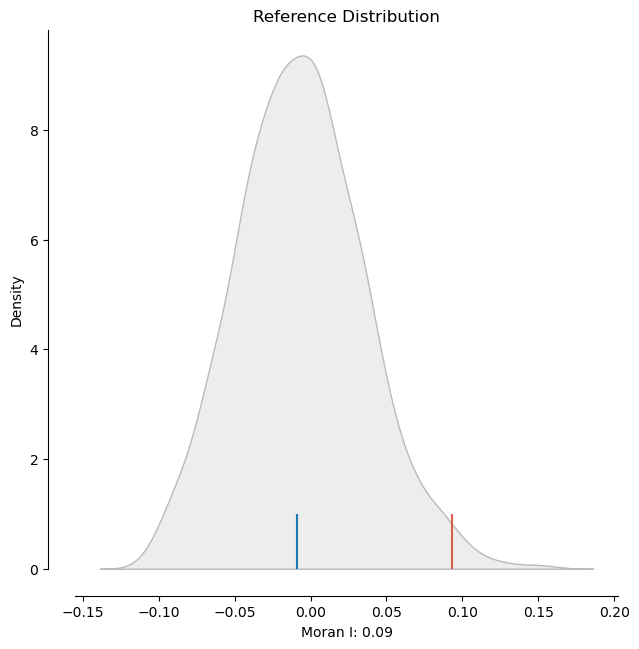

In [37]:
plot_moran_simulation(moran_enviro,aspect_equal=False)

In [38]:
moran_enviro.p_sim

0.014

# Educational Domain

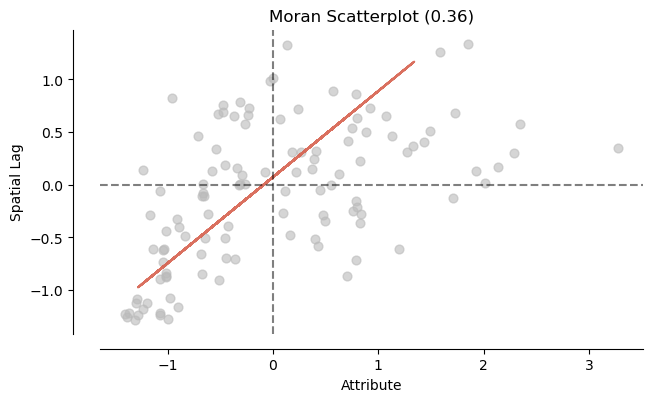

In [39]:
fig, ax = moran_scatterplot(moran_education, aspect_equal=True)
plt.show()

/opt/conda/lib/python3.10/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


(<Figure size 700x700 with 1 Axes>,
 <AxesSubplot: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.36', ylabel='Density'>)

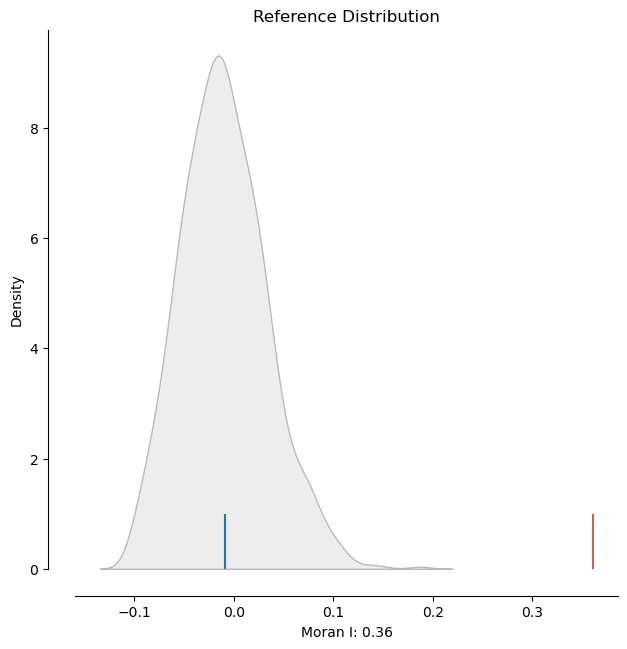

In [40]:
plot_moran_simulation(moran_education,aspect_equal=False)

In [41]:
moran_education.p_sim

0.001

### Statistically Significant?? Yes! in all three domains - p-values are less than 0.05 - which means that the distribution of economic, environmental, and educational opportunity is not random in the city of Los Angeles and that there is a positive spatial autocorrelation: high values are close to high values, and/or low values are close to low values (for all three domains)
From class - The value is calculated as an empirical P-value that represents the proportion of realisations in the simulation under spatial randomness that are more extreme than the observed value. A small enough p-value associated with the Moran’s I of a map allows to reject the hypothesis that the map is random. In other words, we can conclude that the map displays more spatial pattern than we would expect if the values had been randomly allocated to a locations.

## Local Indicators of Spatial Association (LISA) is used to do that. LISA classifies areas into four groups: high values near to high values (HH), Low values with nearby low values (LL), Low values with high values in its neighborhood, and vice-versa.

### Entire Index Lag

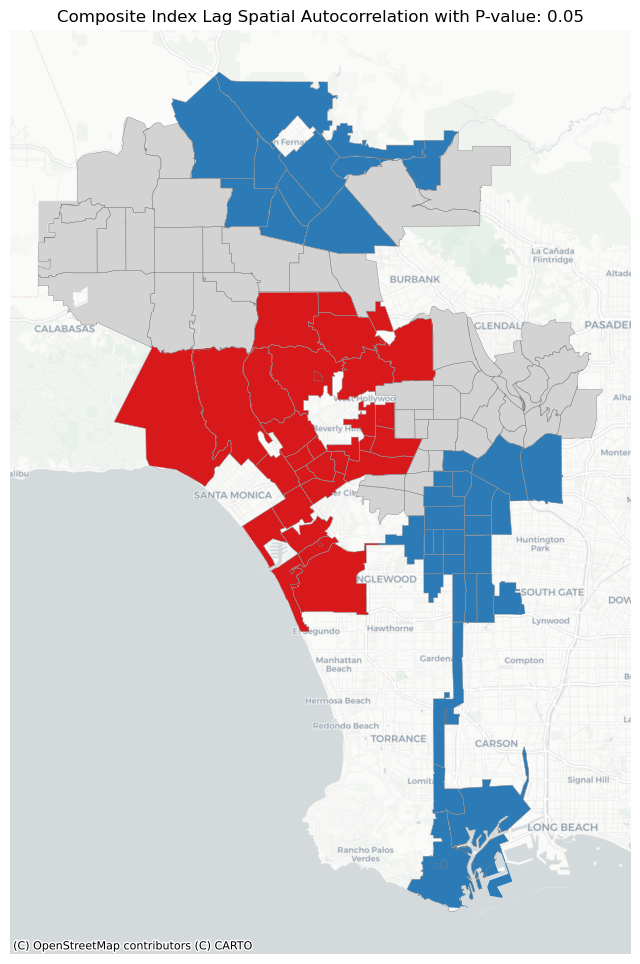

In [46]:
#plot the data
TCACNeighborhoods_web_mercator.set_index
y = TCACNeighborhoods_web_mercator['index_lag']
moran = Moran(y, wq)
moran.I


lisa = esda.moran.Moran_Local(y, wq)
    
fig, ax = plt.subplots(1,figsize=(20, 12))

lisa_cluster(lisa, TCACNeighborhoods_web_mercator, p=0.05, ax=ax
            )

neighborhoods_web_mercator.plot(
            ax=ax,                
            color = "none",        
            edgecolor = 'grey',
            linewidth = 0.3,
            )

ax.axis("off")
ax.set_title("Composite Index Lag Spatial Autocorrelation with P-value: 0.05")
ax.get_legend().remove()
 
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)
plt.show()


### Economic Domain

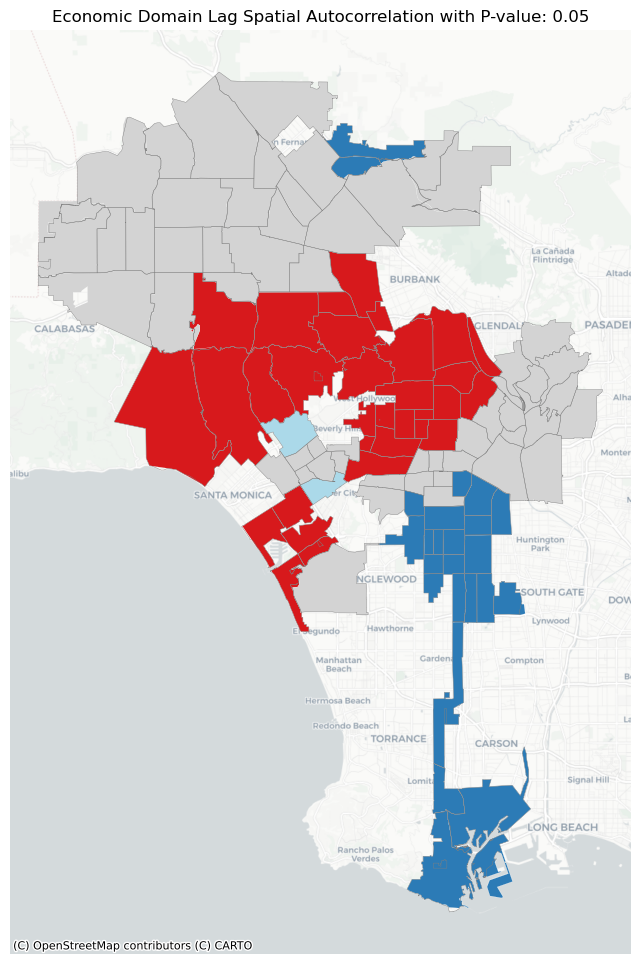

In [47]:
#plot the data
TCACNeighborhoods_web_mercator.set_index
y = TCACNeighborhoods_web_mercator['ecn_dmn_lag']
moran = Moran(y, wq)
moran.I

lisa = esda.moran.Moran_Local(y, wq)
    
fig, ax = plt.subplots(1,figsize=(20, 12))

lisa_cluster(lisa, TCACNeighborhoods_web_mercator, p=0.05, ax=ax)

neighborhoods_web_mercator.plot(
            ax=ax,                
            color = "none",        
            edgecolor = 'grey',
            linewidth = 0.3,
            )

ax.axis("off")
ax.set_title("Economic Domain Lag Spatial Autocorrelation with P-value: 0.05")
ax.get_legend().remove()

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)
plt.show()

  

### Educational

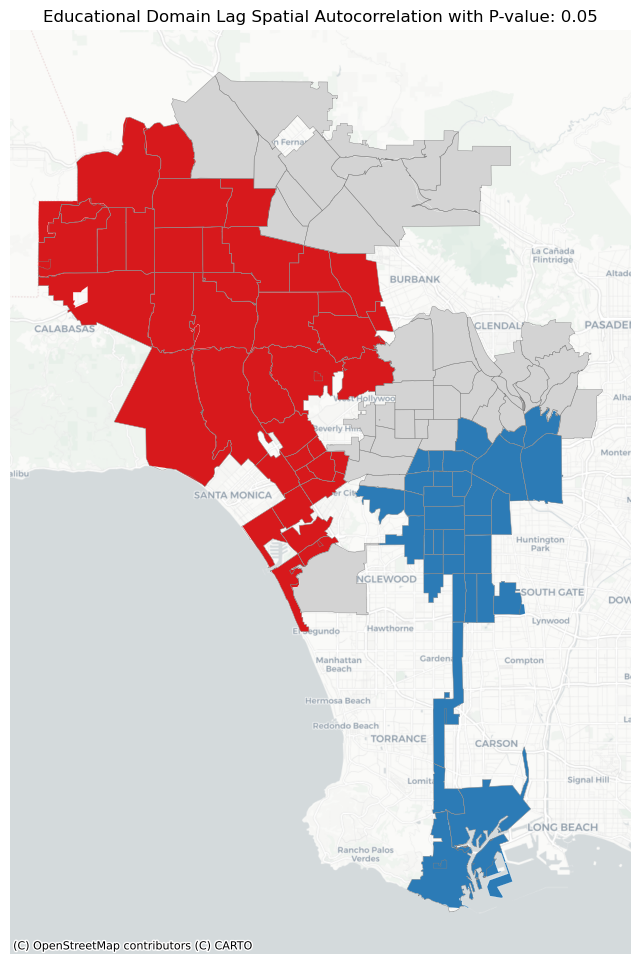

In [48]:
#plot the data
TCACNeighborhoods_web_mercator.set_index
y = TCACNeighborhoods_web_mercator['ed_domn_lag']
moran = Moran(y, wq)
moran.I

lisa = esda.moran.Moran_Local(y, wq)
    
fig, ax = plt.subplots(1,figsize=(20, 12))

lisa_cluster(lisa, TCACNeighborhoods_web_mercator, p=0.05, ax=ax)

neighborhoods_web_mercator.plot(
            ax=ax,                
            color = "none",        
            edgecolor = 'grey',
            linewidth = 0.3,
            )

ax.axis("off")
ax.set_title("Educational Domain Lag Spatial Autocorrelation with P-value: 0.05")
ax.get_legend().remove()

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)
plt.show()

### Environmental

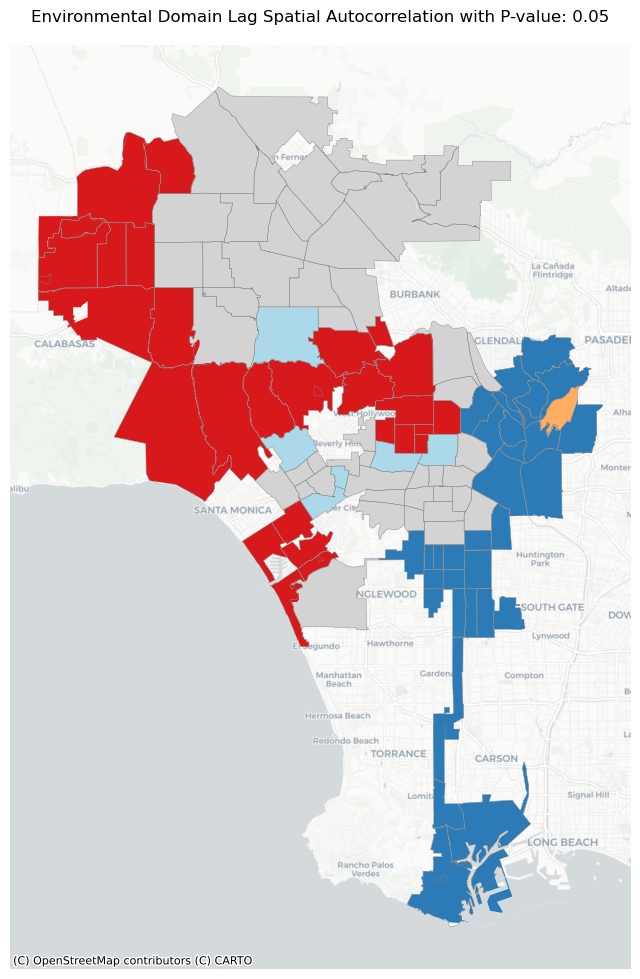

In [49]:
TCACNeighborhoods_web_mercator.set_index
y = TCACNeighborhoods_web_mercator['env_hl_lag']
moran = Moran(y, wq)
moran.I


lisa = esda.moran.Moran_Local(y, wq)
    
fig, ax = plt.subplots(1,figsize=(20, 12))

# regular count map on the left
lisa_cluster(lisa, TCACNeighborhoods_web_mercator, p=0.05, ax=ax)

neighborhoods_web_mercator.plot(
            ax=ax,                
            color = "none",        
            edgecolor = 'grey',
            linewidth = 0.3,
            )

ax.axis("off")
ax.set_title("Environmental Domain Lag Spatial Autocorrelation with P-value: 0.05")
ax.get_legend().remove()

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)
plt.show()
